In [59]:
import requests
import glob
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from functools import reduce
from ta.momentum import rsi
from ta.trend import ema_indicator
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot

In [18]:
# data collection
all_markets = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
col_list = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume", "number_of_trade", "ignore1", "ignore2", "ignore3"]

for market in all_markets:
    df = pd.DataFrame(columns=col_list)
    startTime = 1622419200000  # 2021-05-31 00:00:00 -> 1 month for cointegration test + 1 day for technical indicator
    endTime = 1648684800000    # 2022-03-31 23:59:59
    while startTime < endTime:
        url = f"https://api.binance.com/api/v3/klines?symbol={market}USDT&interval=1m&startTime={startTime}&limit=1000"
        data = pd.DataFrame(requests.get(url).json(), columns=col_list)
        df = pd.concat([df, data])
        startTime = df.close_time.iloc[-1] + 1
    df.to_csv(market+".csv")

In [40]:
df = pd.DataFrame(columns=col_list)
startTime = 1622419200000  # 2021-05-31 00:00:00 -> 1 month for cointegration test + 1 day for technical indicator
endTime = 1648684800000    # 2022-03-31 23:59:59
while startTime < endTime:
    url = f"https://api.binance.com/api/v3/klines?symbol=BTCUSDT&interval=1m&startTime={startTime}&limit=1000"
    data = pd.DataFrame(requests.get(url).json(), columns=col_list)
    df = pd.concat([df, data])
    startTime = df.close_time.iloc[-1] + 1
df.to_csv("BTC.csv")

In [19]:
# formatting the csv file into ohlcv
token_list = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
for i in glob.glob("data/*.csv"):
    df = pd.read_csv(i, index_col=0)
    df["time"] = (df["open_time"]/1000).apply(datetime.utcfromtimestamp)
    df.set_index("time", drop=True, inplace=True)
    df = df[["open", "high", "low", "close", "quote_asset_volume"]]
    df.columns = ["open", "high", "low", "close", "volume"]
    df.to_csv(i)

In [20]:
# aligning the time & backfill the missing data
df_list = []
for i in glob.glob("data/*.csv"):
    token_name = i.split("/")[1].split(".")[0]
    df = pd.read_csv(i, index_col=0)
    col = [token_name + "_" + col_name for col_name in df.columns]
    df.columns = col
    df_list.append(df)

master_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="outer"), df_list)
master_df.fillna(method="ffill", inplace=True)
master_df = master_df.loc[:"2022-04-01"]

# splitting back into individual csv files
for token in token_list:
    cols = [col for col in master_df.columns if col.startswith(token)]
    df = master_df[cols]
    df.columns = [col.split("_")[1] for col in cols]
    df.to_csv(f"data/{token}.csv")

In [47]:
# populating features & confining time index to predetermined time horizon
for i in glob.glob("data/*.csv"):
    df = pd.read_csv(i, index_col=0, parse_dates=True)
    df["log_rtn"] = np.log(df["close"]).diff()
    for window in [30, 60, 240, 480, 720, 1440]:
        df[f"{window}_ema"] = ema_indicator(df.close, window)
        df[f"{window}_rsi"] = rsi(df.close, window)
        df[f"{window}_vol"] = df["log_rtn"].rolling(window).std()
    df = df.loc["2021-06-01":"2022-03-31"]
    df.to_csv(i)

In [11]:
##################################################################################
###########  END OF DATA ACQUISITION - DO NOT RUN CODE ABOVE THIS CELL ###########
##################################################################################

In [2]:
# reading data
token_list = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
pre_data = {}
data = {}
for token in token_list:
    df = pd.read_csv(f"data/{token}.csv", index_col=0, parse_dates=True)
    pre_data[token] = df.loc[:"2021-06-30"]
    data[token] = df.loc["2021-07-01":]

In [3]:
# clustering using NearestNeighbor using the first data point
# getting the cluster data
cluster_data = pd.DataFrame(columns=token_list)
for token in token_list:
    cluster_data[token] = pre_data[token].iloc[0]
cluster_data = cluster_data.T

# NearestNeighbor
nn = NearestNeighbors(n_neighbors=4)
nn.fit(cluster_data)
neigh = nn.kneighbors()[1]

# Pairs for cointegration test
token0 = [token for token in token_list for i in range(4)]
token1 = [token_list[i] for i in neigh.ravel()]
pairs = pd.DataFrame()
pairs ["pair"] = [list(a) for a in zip(token0, token1)]
pairs ["rev"] = [list(a) for a in zip(token1, token0)]
drop = []
for i in range(len(pairs)):
    if pairs.iloc[i]["rev"] in pairs["pair"].to_list()[i:]:
        drop.append(i)
pairs = pairs.drop(drop, axis=0)["pair"].reset_index(drop=True).to_list()
len(pairs)

38

In [5]:
pairs

[['BTC', 'ADA'],
 ['BTC', 'BNB'],
 ['BTC', 'XRP'],
 ['ETH', 'BTC'],
 ['ETH', 'ADA'],
 ['ETH', 'BNB'],
 ['ETH', 'XRP'],
 ['DOGE', 'ZIL'],
 ['XRP', 'BNB'],
 ['ZIL', 'TRX'],
 ['ADA', 'BNB'],
 ['ADA', 'XRP'],
 ['ADA', 'LINK'],
 ['WAVES', 'TRX'],
 ['WAVES', 'ZIL'],
 ['ETC', 'DOGE'],
 ['ETC', 'ZIL'],
 ['LTC', 'ETC'],
 ['LTC', 'DOGE'],
 ['LTC', 'ZIL'],
 ['MATIC', 'XRP'],
 ['MATIC', 'BNB'],
 ['MATIC', 'ADA'],
 ['LINK', 'MATIC'],
 ['LINK', 'XRP'],
 ['LINK', 'BNB'],
 ['LINK', 'EOS'],
 ['EOS', 'DOGE'],
 ['EOS', 'ETC'],
 ['EOS', 'LTC'],
 ['EOS', 'ZIL'],
 ['ATOM', 'WAVES'],
 ['ATOM', 'TRX'],
 ['ATOM', 'ZIL'],
 ['XLM', 'TRX'],
 ['XLM', 'WAVES'],
 ['XLM', 'ATOM'],
 ['XLM', 'ZIL']]

In [6]:
# cointegration test for all pairs
coint_pairs = []
coint_tstat = []
for pair in pairs:
    price0 = pre_data[pair[0]]["close"]
    price1 = pre_data[pair[1]]["close"]
    res = coint(price0, price1)
    tstat, pval = res[0], res[1]
    if pval < 0.05:
        coint_pairs.append(pair)
        coint_tstat.append(tstat)
        print(f"{pair[0]} - {pair[1]}")
        print(f"It is co integrated with pval - {pval}, tstat - {tstat}")
        print()

DOGE - ZIL
It is co integrated with pval - 0.0050752332870706044, tstat - -4.104010893265754

XRP - BNB
It is co integrated with pval - 0.0002645564067924882, tstat - -4.886678326778122

ADA - BNB
It is co integrated with pval - 0.020962227093316087, tstat - -3.654189493188102

ADA - XRP
It is co integrated with pval - 0.01810691583984039, tstat - -3.7040492141361216

ADA - LINK
It is co integrated with pval - 0.00430959294455947, tstat - -4.151885073323475

LTC - DOGE
It is co integrated with pval - 0.00826938541919443, tstat - -3.9567262774241803

LTC - ZIL
It is co integrated with pval - 0.003517799330564573, tstat - -4.210386626931956

MATIC - BNB
It is co integrated with pval - 0.020827105793967588, tstat - -3.656411422242147



KeyboardInterrupt: 

In [52]:
# choosing the most cointegrated pairs - EOS-ZIL
coint_df = pd.DataFrame({"pairs": coint_pairs,
                         "tstat": coint_tstat})
coint_df.sort_values(by="tstat", ascending=True).reset_index(drop=True)

,pairs,tstat
0,"[EOS, ZIL]",-5.388334
1,"[EOS, DOGE]",-5.311655
2,"[XRP, BNB]",-4.886678
3,"[ATOM, ZIL]",-4.529478
4,"[XLM, ZIL]",-4.370721
5,"[LINK, BNB]",-4.352107
6,"[LTC, ZIL]",-4.210387
7,"[ADA, LINK]",-4.151885
8,"[DOGE, ZIL]",-4.104011
9,"[LTC, DOGE]",-3.956726


In [53]:
# Finding hedge ratio for each of the cointegrated pairs using OLS regression - using more expensive token as y
# EOS-ZIL
lr1 = LinearRegression()
lr1.fit(pre_data["ZIL"]["close"].values.reshape(-1,1), pre_data["EOS"]["close"])
print(f"1 EOS = {float(lr1.coef_)} ZIL")
print()

1 EOS = 44.36561187799406 ZIL



In [62]:
# code snippet for denoising with wavelet transform demonstration with close price of ZIL
denoised_coeff = []
filt = pywt.Wavelet("haar")
max_level = pywt.dwt_max_level(len(data["ZIL"]), filt.dec_len)
series = pywt.wavedec(data["ZIL"].close, "haar", level=2) # choose the level depending on how "strong" the filtering you want to be, larger value = more smoothing, between 2 to max_level
for i in series:
    denoise = pywt.threshold(i, np.std(i))
    denoised_coeff.append(denoise)
denoised_signal = pywt.waverec(denoised_coeff, "haar")

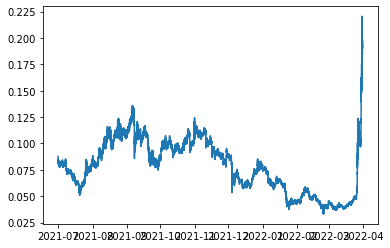

In [63]:
# original signal
plt.plot(data["ZIL"].close)

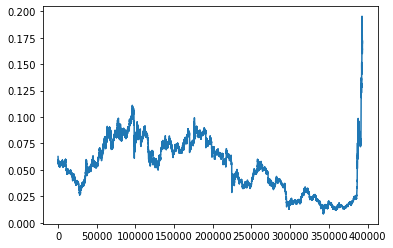

In [64]:
# denoised signal
plt.plot(denoised_signal)

In [ ]:
#Preapare for the training and the testing data of the pair data

In [10]:
choosen_pair_token=["EOS", "ZIL"]

In [7]:
pair_data = pd.DataFrame({'S1_close':data['ZIL']['close'],'S2_close':data['EOS']['close']
                         ,'S1_open':data['ZIL']["open"],'S2_open':data['EOS']["open"]
                         ,'S1_high':data['ZIL']["high"],'S2_high':data['EOS']["high"]
                         ,'S1_low':data['ZIL']["low"],'S2_low':data['EOS']["low"]
                         ,'S1_volume':data['ZIL']["volume"],'S2_volume':data['EOS']["volume"]})

In [11]:
col_list=data["ZIL"].columns[6:24]
for col in col_list:
    for cols in choosen_pair_token:
        n=choosen_pair_token.index(cols)
        n=n+1
        Strings="S"+str(n)+"_"+col
        pair_data[Strings]=data[cols][col]


In [12]:
pair_data.columns

Index(['S1_close', 'S2_close', 'S1_open', 'S2_open', 'S1_high', 'S2_high',
       'S1_low', 'S2_low', 'S1_volume', 'S2_volume', 'S1_30_ema', 'S2_30_ema',
       'S1_30_rsi', 'S2_30_rsi', 'S1_30_vol', 'S2_30_vol', 'S1_60_ema',
       'S2_60_ema', 'S1_60_rsi', 'S2_60_rsi', 'S1_60_vol', 'S2_60_vol',
       'S1_240_ema', 'S2_240_ema', 'S1_240_rsi', 'S2_240_rsi', 'S1_240_vol',
       'S2_240_vol', 'S1_480_ema', 'S2_480_ema', 'S1_480_rsi', 'S2_480_rsi',
       'S1_480_vol', 'S2_480_vol', 'S1_720_ema', 'S2_720_ema', 'S1_720_rsi',
       'S2_720_rsi', 'S1_720_vol', 'S2_720_vol', 'S1_1440_ema', 'S2_1440_ema',
       'S1_1440_rsi', 'S2_1440_rsi', 'S1_1440_vol', 'S2_1440_vol'],
      dtype='object')

In [13]:
col_for_cal_spread=data["ZIL"].columns[0:4]
for col in col_for_cal_spread:
    lr=LinearRegression()
    S_one="S1_"+col
    S_two="S2_"+col
    lr.fit(pair_data[S_one].values.reshape(-1,1),pair_data[S_two].values.reshape(-1,1))
    spread_coef=-lr.coef_[0]
    String_spread="Spread_"+col
    pair_data[String_spread]=pair_data[S_one]+(pair_data[S_two]*spread_coef)


In [14]:
cols_trained=pair_data.columns[8:]
lstm_pair_data=pair_data[cols_trained].copy()


In [15]:
#count how many data point for each day
n=0
for i in range(10000):
    if "2021-07-01" in str(lstm_pair_data.index[i]):
        n=n+1
#n=1440

In [ ]:
#Wavelet Denoising

In [16]:
def wav_den(ts_orig):
    (ca, cd) = pywt.dwt(ts_orig, 'db8')
    cat = pywt.threshold(ca, np.std(ca)/8, mode='soft')
    cdt = pywt.threshold(cd, np.std(cd)/8, mode='soft')
    ts_rec = pywt.idwt(cat, cdt, 'db8')
    return ts_rec[1:]


In [ ]:
#testing_size: 15 days

In [50]:
train_size=int(len(lstm_pair_data.index)*0.9)
test_size=1440*15
validation_size=int(len(lstm_pair_data.index)-(train_size+test_size))


train= lstm_pair_data[0:train_size]
dev=lstm_pair_data[train_size: (train_size+validation_size)]
test=lstm_pair_data[int(len(lstm_pair_data))-test_size:int(len(lstm_pair_data))]


In [49]:
test.shape

(21600, 42)

In [51]:
cols=lstm_pair_data.columns
train_den = pd.DataFrame(columns = cols)
for col in cols:
    train_den[col] = wav_den(train[col])

In [139]:
train_den.columns

Index(['S1_volume', 'S2_volume', 'S1_30_ema', 'S2_30_ema', 'S1_30_rsi',
       'S2_30_rsi', 'S1_30_vol', 'S2_30_vol', 'S1_60_ema', 'S2_60_ema',
       'S1_60_rsi', 'S2_60_rsi', 'S1_60_vol', 'S2_60_vol', 'S1_240_ema',
       'S2_240_ema', 'S1_240_rsi', 'S2_240_rsi', 'S1_240_vol', 'S2_240_vol',
       'S1_480_ema', 'S2_480_ema', 'S1_480_rsi', 'S2_480_rsi', 'S1_480_vol',
       'S2_480_vol', 'S1_720_ema', 'S2_720_ema', 'S1_720_rsi', 'S2_720_rsi',
       'S1_720_vol', 'S2_720_vol', 'S1_1440_ema', 'S2_1440_ema', 'S1_1440_rsi',
       'S2_1440_rsi', 'S1_1440_vol', 'S2_1440_vol', 'Spread_open',
       'Spread_high', 'Spread_low', 'Spread_close'],
      dtype='object')

In [140]:
#Comparison of the performance of the model using different optimizers

In [174]:
# generate the dataset with normalization and set the y as the volume

In [123]:

look_back=1
scaler = MinMaxScaler(feature_range=(0, 1))
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 0])
    print(len(dataY))
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

# Generate dataset for trainX, trainY, testX, testY
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train_den.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

354022
17735
21599


In [124]:
def acc_metric(true_value, predicted_value):
    acc_met = 0.0
    m = len(true_value)
    for i in range(m):
        acc_met += mean_squared_error(true_value[i], predicted_value[i])
    acc_met /= m
    return np.sqrt(acc_met)

In [ ]:
#optimizer:Adam

In [125]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
devX = np.reshape(devX, (devX.shape[0], 1, devX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Running the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(look_back))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 256)            306176    
                                                                 
 lstm_6 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 831,745
Trainable params: 831,745
Non-trainable params: 0
_________________________________________________________________


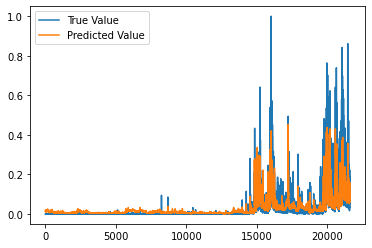

In [60]:
yhat = model.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [81]:
prediction_data=pd.DataFrame(yhat)

In [83]:
prediction_data.to_csv("data/prediction_data_1.csv")

In [84]:
#root mean square error
acc_metric(testY,yhat)

0.032425342038178595

In [ ]:
#time taken in the model using Adam: 5 hours

In [ ]:
#Using SGD

In [86]:
model_1 = Sequential()
model_1.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model_1.add(LSTM(256))
model_1.add(Dropout(0.2))
model_1.add(Dense(look_back))
model_1.compile(loss='mse', optimizer='SGD', metrics=['accuracy'])
history = model_1.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

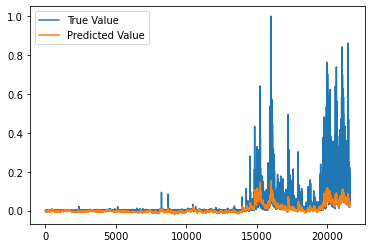

In [87]:
yhat_1 = model_1.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat_1, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [91]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 256)            306176    
                                                                 
 lstm_10 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 831,745
Trainable params: 831,745
Non-trainable params: 0
_________________________________________________________________


In [88]:
acc_metric(testY,yhat_1)

0.04614133847344337

In [90]:
prediction_data_2=pd.DataFrame(yhat_1)
prediction_data_2.to_csv("data/prediction_data_2.csv")

In [ ]:
#time taken in the model using SGD: 5 hours

In [ ]:
#using RMSprop

In [93]:
model_3 = Sequential()
model_3.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model_3.add(LSTM(256))
model_3.add(Dropout(0.2))
model_3.add(Dense(look_back))
model_3.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy'])
history = model_3.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

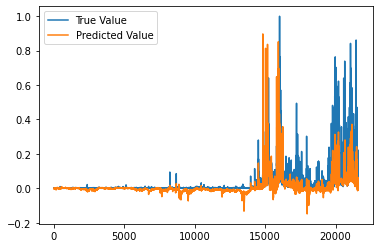

In [94]:
yhat_2 = model_3.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat_2, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [95]:
acc_metric(testY,yhat_2)

0.045788569356027105

In [96]:
prediction_data_3=pd.DataFrame(yhat_2)
prediction_data_3.to_csv("data/prediction_data_3.csv")

In [ ]:
#time taken in the model using RMSprop: 6 hours

In [ ]:
#real model in predicting the spread_close using Adam in LSTM

In [ ]:
look_back=1
scaler = MinMaxScaler(feature_range=(0, 1))
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 41])
    print(len(dataY))
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

# Generate dataset for trainX, trainY, testX, testY
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train_den.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
devX = np.reshape(devX, (devX.shape[0], 1, devX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Running the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(look_back))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

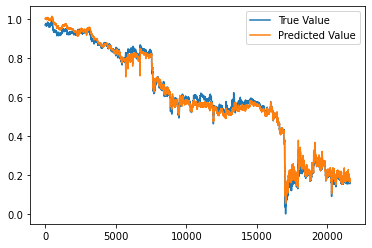

In [126]:
yhat_t = model.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat_t, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [127]:
acc_metric(testY,yhat_t)

0.02143371782517037

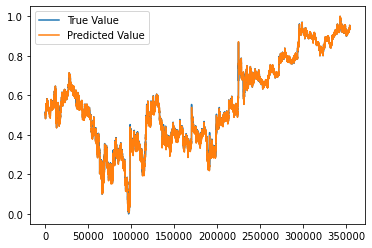

In [137]:
yhat_tx = model.predict(trainX)
pyplot.plot(trainY, label='True Value')
pyplot.plot(yhat_tx, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [138]:
acc_metric(trainY,yhat_tx)

0.002522211726790157

In [128]:
prediction_data_t=pd.DataFrame(yhat_t)
prediction_data_t.to_csv("data/prediction_data_t.csv")

In [131]:
test_Y=pd.DataFrame(testY)
test_Y.to_csv("data/testY.csv")

In [136]:
test_X=pd.DataFrame(testX.reshape(testX.shape[0],testX.shape[2]))
test_X.to_csv("data/testX.csv")